### 18.5. BERT

IMDB 영화평 데이터셋 주소

https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

텍스트 토큰화

In [1]:
using Transformers
using Transformers.TextEncoders
using Transformers.HuggingFace
ENV["DATADEPS_ALWAYS_ACCEPT"] = true # 필요 데이터 자동 다운로드
import Flux

bert_enc, bert_model = hgf"bert-base-uncased"
bert_model = bert_model |> Flux.gpu

HGFBertModel(
  Chain(
    CompositeEmbedding(
      token = Embed(768, 30522),        # 23_440_896 parameters
      position = ApplyEmbed(.+, FixedLenPositionEmbed(768, 512)),  # 393_216 parameters
      segment = ApplyEmbed(.+, Embed(768, 2), Transformers.HuggingFace.bert_ones_like),  # 1_536 parameters
    ),
    DropoutLayer<nothing>(
      LayerNorm(768, ϵ = 1.0e-12),      # 1_536 parameters
    ),
  ),
  Transformer<12>(
    PostNormTransformerBlock(
      DropoutLayer<nothing>(
        SelfAttention(
          MultiheadQKVAttenOp(head = 12, p = nothing),
          Fork<3>(Dense(W = (768, 768), b = true)),  # 1_771_776 parameters
          Dense(W = (768, 768), b = true),  # 590_592 parameters
        ),
      ),
      LayerNorm(768, ϵ = 1.0e-12),      # 1_536 parameters
      DropoutLayer<nothing>(
        Chain(
          Dense(σ = NNlib.gelu, W = (768, 3072), b = true),  # 2_362_368 parameters
          Dense(W = (3072, 768), b = true),  # 2_360_064 parameters
        ),
     

특성 추출

In [13]:
using CSV, DataFrames
import MLUtils, FileIO

function extract_features(bert_enc, bert_model)
    imdb = CSV.read("/home/tyfun/Downloads/IMDB Dataset.csv", DataFrame)
    X = replace.(imdb.review, "<br />" => " ")
    chunk_size = 100
    features = []
    for (i, c) in enumerate(Flux.chunk(X, size=chunk_size))
        i % 10 == 0 && println("$(chunk_size * i) / $(length(X))")
        c = encode(bert_enc, collect(c))
        c = c |> Flux.gpu
        f = bert_model(c).hidden_state[:,1,:]
        f = MLUtils.unbatch(f) |> Flux.cpu
        features = vcat(features, f)
    end
    X = MLUtils.batch(features)

    y = ifelse.(imdb.sentiment .== "positive", 1, 0);
    y = Flux.onehotbatch(y, 0:1)

    FileIO.save("imdb_bert_feat.jld2", Dict("X" => X, "y" => y)) 
end

extract_features (generic function with 1 method)

In [14]:
extract_features(bert_enc, bert_model)

1000 / 50000
2000 / 50000
3000 / 50000
4000 / 50000
5000 / 50000
6000 / 50000
7000 / 50000
8000 / 50000
9000 / 50000
10000 / 50000
11000 / 50000
12000 / 50000
13000 / 50000
14000 / 50000
15000 / 50000
16000 / 50000
17000 / 50000
18000 / 50000
19000 / 50000
20000 / 50000
21000 / 50000
22000 / 50000
23000 / 50000
24000 / 50000
25000 / 50000
26000 / 50000
27000 / 50000
28000 / 50000
29000 / 50000
30000 / 50000
31000 / 50000
32000 / 50000
33000 / 50000
34000 / 50000
35000 / 50000
36000 / 50000
37000 / 50000
38000 / 50000
39000 / 50000
40000 / 50000
41000 / 50000
42000 / 50000
43000 / 50000
44000 / 50000
45000 / 50000
46000 / 50000
47000 / 50000
48000 / 50000
49000 / 50000
50000 / 50000


In [15]:
function get_data(batchsize = 64)
    dic = FileIO.load("imdb_bert_feat.jld2") 
    X, y = dic["X"], dic["y"]
    train, test = MLUtils.splitobs((X, y), at = 0.7);
    train_loader = MLUtils.DataLoader(train, batchsize=batchsize)#, shuffle=true)
    test_loader = MLUtils.DataLoader(test, batchsize=batchsize)
    
    return train_loader, test_loader
end

get_data (generic function with 4 methods)

학습 및 테스트, 실행 함수 (16장 함수와 동일)

In [16]:
import Flux, Optimisers, Zygote, Functors
using Formatting: printfmtln
using Random: MersenneTwister

function train(loader, model, loss_fn, optimizer)
    num_batches = length(loader)
    losses = Float32[]
    Flux.testmode!(model, false)
    for (batch, (X, y)) in enumerate(loader)
        X, y = Flux.gpu(X), Flux.gpu(y)
        grad = Zygote.gradient(m -> loss_fn(m(X), y), model)[1]
        optimizer, model = Optimisers.update(optimizer, model, grad)
        if batch % 100 == 0
            loss = loss_fn(model(X), y)
            printfmtln("[Train] loss: {:.7f} [{:>3d}/{:>3d}]", 
                loss, batch, num_batches)
            push!(losses, loss)
        end
    end
    model, optimizer, losses
end

function test(loader, model, loss_fn)
    num_batches = length(loader)
    Flux.testmode!(model, true)
    acc, tot = 0, 0
    loss = 0f0
    for (X, y) in loader
        X, y = Flux.gpu(X), Flux.gpu(y)
        pred = model(X)
        acc += sum(Flux.onecold(pred) .== Flux.onecold(y))
        #acc += sum((pred .> 0) .== (y .== 1))
        tot += size(X)[end]
        loss += loss_fn(pred, y)
    end
    acc, avg_loss = acc / tot * 100, loss / num_batches
    printfmtln("[Test] Accuracy: {:.1f}, Avg loss: {:.7f}", 
        acc, avg_loss)
    acc, avg_loss
end

function run_epochs(loaders, model, loss_fn, optimizer, epochs)
    train_loader, test_loader = loaders
    train_losses, accuracies = [], [];
    for t in 1:epochs
        println("Epoch $t")
        println("-------------------------------")
        model, optimizer, losses = 
            train(train_loader, model, loss_fn, optimizer)
        train_losses = vcat(train_losses, losses)
        acc, _ = test(test_loader, model, loss_fn)
        push!(accuracies, acc)
    end
    train_losses, accuracies
end

init(rng) = Flux.glorot_uniform(rng)

init (generic function with 1 method)

분류 모델 정의 및 학습

In [17]:
rng = MersenneTwister(1)
model = Flux.Dense(768 => 2; init=init(rng)) |> Flux.gpu
loss_fn = Flux.Losses.logitcrossentropy
optimizer = Optimisers.setup(Optimisers.Adam(), model);
_, accuracies = run_epochs(get_data(), model, loss_fn, optimizer, 20)

Epoch 1
-------------------------------
[Train] loss: 0.4591583 [100/547]
[Train] loss: 0.3394652 [200/547]
[Train] loss: 0.3911191 [300/547]
[Train] loss: 0.2921277 [400/547]
[Train] loss: 0.2025619 [500/547]
[Test] Accuracy: 85.0, Avg loss: 0.3407870
Epoch 2
-------------------------------
[Train] loss: 0.3922372 [100/547]
[Train] loss: 0.2965587 [200/547]
[Train] loss: 0.3679918 [300/547]
[Train] loss: 0.2639512 [400/547]
[Train] loss: 0.1919470 [500/547]
[Test] Accuracy: 85.6, Avg loss: 0.3263290
Epoch 3
-------------------------------
[Train] loss: 0.3843241 [100/547]
[Train] loss: 0.2934236 [200/547]
[Train] loss: 0.3623451 [300/547]
[Train] loss: 0.2562061 [400/547]
[Train] loss: 0.1872739 [500/547]
[Test] Accuracy: 86.1, Avg loss: 0.3199490
Epoch 4
-------------------------------
[Train] loss: 0.3789037 [100/547]
[Train] loss: 0.2938623 [200/547]
[Train] loss: 0.3591653 [300/547]
[Train] loss: 0.2541201 [400/547]
[Train] loss: 0.1838240 [500/547]
[Test] Accuracy: 86.3, Avg loss

(Any[0.4591583f0, 0.3394652f0, 0.3911191f0, 0.29212767f0, 0.2025619f0, 0.39223722f0, 0.29655868f0, 0.36799175f0, 0.26395124f0, 0.19194698f0  …  0.34526306f0, 0.2935255f0, 0.34306216f0, 0.27012253f0, 0.17102098f0, 0.3440554f0, 0.293275f0, 0.3425355f0, 0.27085817f0, 0.17084795f0], Any[85.04, 85.61999999999999, 86.06666666666666, 86.26666666666667, 86.45333333333333, 86.64, 86.72666666666666, 86.83999999999999, 86.89333333333333, 86.95333333333333, 86.95333333333333, 86.98, 87.04666666666667, 87.06, 87.08666666666667, 87.08, 87.12, 87.10666666666667, 87.12, 87.14666666666666])

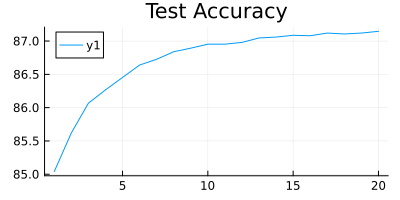

In [18]:
import Plots
Plots.gr(size=(400,200))
title = "Test Accuracy"
Plots.plot(accuracies, title=title)